In [ ]:
from tensorflow import keras
from keras import backend
from keras import layers,models
import matplotlib.pyplot as plt
import numpy as np
from keras.constraints import max_norm
class WeightedSum(keras.layers.Add):
    def __init__(self,alpha=0.0,**kwargs):
        super(WeightedSum,self).__init__(**kwargs)
        self.alpha = backend.variable(alpha,name='ws_alpha')

    def _merge_function(self,inputs):
        assert(len(inputs)==2)
        output = ((1.0-self.alpha)*inputs[0])+(self.alpha*inputs[1])
        return output

class MinibatchStdev(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(MinibatchStdev,self).__init__(**kwargs)

    def call(self,inputs):
        mean = backend.mean(inputs,axis=0,keepdims=True)
        squ_diffs = backend.square(inputs-mean)
        mean_sq_diff = backend.mean(squ_diffs,axis=0,keepdims=True) + 1e-8
        stdev = backend.sqrt(mean_sq_diff)
        mean_pix = backend.mean(stdev,keepdims=True)
        shape = backend.shape(inputs)
        output = backend.tile(mean_pix,(shape[0],shape[1],shape[2],1))
        combined = backend.concatenate([inputs,output],axis=-1)
        return combined

class PixelNormalization(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(PixelNormalization,self).__init__(**kwargs)

    def call(self,inputs):
        values = inputs ** 2.0
        mean_values = backend.mean(values,axis=-1,keepdims=True) + 1e-8
        l2 = backend.sqrt(mean_values)
        normalized = inputs/l2
        return normalized
    
    def compute_output_shape(self,input_shape):
        return input_shape

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
x_train = np.load('/content/drive/MyDrive/dataset_2.npy')
#dataset = np.load('/content/drive/MyDrive/PROGANMAIN/mydataset.npy')

In [ ]:
def add_disc(old_model,filters):
    const = max_norm(1.0)
    in_shape = list(old_model.input.shape)
    init = keras.initializers.RandomNormal()
    input_shape = (in_shape[-2]*2,in_shape[-2]*2,in_shape[-1])
    input_image = models.Input(shape=input_shape)
    x = layers.Conv2D(filters,1,padding='same',kernel_initializer=init,kernel_constraint=const)(input_image)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(filters,3,padding='same',kernel_initializer=init,kernel_constraint=const)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(filters*2,3,padding='same',kernel_initializer=init,kernel_constraint=const)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.AveragePooling2D()(x)
    new_block = x
    for i in range(3,len(old_model.layers)):
        x = old_model.layers[i](x)
    model1 = models.Model(input_image,x)
    y = layers.Conv2D(filters*2,3,padding='same',kernel_initializer=init,kernel_constraint=const)(input_image)
    y = layers.LeakyReLU(alpha=0.2)(y)
    y = layers.AveragePooling2D()(y)
    x = WeightedSum()([y,new_block])
    for i in range(3,len(old_model.layers)):
        x = old_model.layers[i](x)
    model2 = keras.models.Model(input_image,x)
    return [model1,model2]

In [ ]:
from tensorflow.keras.utils import plot_model
def define_discriminator(n_blocks,in_shape):
    modeles = []
    const = max_norm(1.0)
    init = keras.initializers.RandomNormal()
    in_image = models.Input(shape=in_shape)
    #x = layers.Conv2D(256,1,padding='same',kernel_initializer='he_normal',kernel_constraint=const)(in_image)
    #x = layers.LeakyReLU(alpha=0.2)(x)
    x = MinibatchStdev()(in_image)
    x = layers.Conv2D(512,3,padding='same',kernel_initializer=init,kernel_constraint=const)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(512,4,strides=4,padding='same',kernel_initializer=init,kernel_constraint=const)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(1,1,padding='same',kernel_initializer=init,kernel_constraint=const)(x)
    out = layers.Flatten()(x)
    model = models.Model(in_image,out)
    modeles.append([model,model])
    for i in range(1,n_blocks):
        old_model = modeles[i-1][0]
        model = add_disc(old_model,512/(2**i))
        modeles.append(model)
    return modeles

disc = define_discriminator(5,(4,4,3))[4][1]
disc.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 64, 64, 32)   128         ['input_5[0][0]']                
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (None, 64, 64, 32)   0           ['conv2d_15[0][0]']              
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 32)   9248        ['leaky_re_lu_14[0][0]']         
                                                                                            

In [ ]:
def add_gen(old_model,filters):
    end = old_model.layers[-2].output
    const = max_norm(1.0)
    init = keras.initializers.RandomNormal()
    up = layers.UpSampling2D()(end)
    x = layers.Conv2D(filters,3,padding='same',kernel_initializer=init,kernel_constraint=const,use_bias=False)(up)
    x = PixelNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters,3,padding='same',kernel_initializer=init,kernel_constraint=const,use_bias=False)(up)
    x = PixelNormalization()(x)
    x = layers.ReLU()(x)
    image_out1 = layers.Conv2D(3,1,padding='same',kernel_initializer=init,kernel_constraint=const,use_bias=False,activation='tanh')(x)
    model1 = models.Model(old_model.input,image_out1)
    old_output = old_model.layers[-1]
    image_out2 = old_output(up)
    fusion = WeightedSum()([image_out2,image_out1])
    model2 = models.Model(old_model.input,fusion)
    return [model1,model2]

In [ ]:
def define_generator(latent_dim,n_blocks):
    modeles = []
    in_latent = models.Input(shape=(latent_dim,))
    const = max_norm(1.0)
    init = keras.initializers.RandomNormal()
    #x = layers.Dense(8*4*4,kernel_initializer='he_normal',kernel_constraint=const)(in_latent)
    x = layers.Reshape((1,1,latent_dim))(in_latent)
    x = layers.Conv2D(latent_dim,4,padding='same',kernel_initializer=init,kernel_constraint=const,use_bias=False)(x)
    x = PixelNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D()(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(latent_dim,3,padding='same',kernel_initializer=init,kernel_constraint=const,use_bias=False)(x)
    x = PixelNormalization()(x)
    x = layers.ReLU()(x)
    out = layers.Conv2D(3,1,padding='same',kernel_initializer=init,kernel_constraint=const,activation='tanh',use_bias=False)(x)
    model = models.Model(in_latent,out)
    modeles.append([model,model])
    for i in range(1,n_blocks):
        old_model = modeles[i-1][0]
        model = add_gen(old_model,latent_dim/(2**i))
        modeles.append(model)
    return modeles

gen = define_generator(512,5)[4][0]
gen.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 512)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 1, 512)         4194304   
                                                                 
 pixel_normalization (PixelN  (None, 1, 1, 512)        0         
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 1, 1, 512)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 2, 2, 512)        0         
 )                                                        

In [ ]:
import tensorflow as tf
#Progan pour une taille donnée
class Progan(keras.Model):
    def __init__(self,generator,discriminator,latent_dim,gp_weight,**kwargs):
        super(Progan,self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.gp_weight = gp_weight

    def compile(self,d_optimizer,g_optimizer,d_loss,g_loss):
        super(Progan,self).compile()
        self.d_opti = d_optimizer
        self.g_opti = g_optimizer
        self.d_loss = d_loss
        self.g_loss = g_loss

    def gradient_penalty(self,batch_size, real_images, fake_images):
        """
        ###Complete gradient_penalty based on Dragan (minimizing regret), refer to article 
        alpha = tf.random.uniform(shape=[tf.shape(real_images)[0],1,1,1],minval=0.0,maxval=1.0)
        perturbed_images = real_images + 0.5*tf.random.uniform(shape=tf.shape(real_images),minval=-1.0,maxval=1.0)
        xi = alpha * real_images + (1-alpha)*perturbed_images
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(xi)
            pred = self.discriminator(xi,training=True)
            grad = gp_tape.gradient(pred,xi)
            norm = tf.sqrt(tf.reduce_sum(grad**2,axis=[1,2]))
            gradient_penalty = tf.reduce_mean((norm-1.0)**2)
        return gradient_penalty
        """
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @tf.function
    def train_step(self,data):
        batch_size = tf.shape(data)[0]
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))
            generated_images = self.generator(random_latent_vectors,training=True)
            fake_logits = self.discriminator(generated_images,training=True)
            real_logits = self.discriminator(data,training=True)
            #combined_images = tf.concat([data,generated_images],axis=0)
            gp = self.gradient_penalty(batch_size,data,generated_images)
            #labels = tf.concat([tf.ones((batch_size,1))-0.1*tf.random.uniform((batch_size,1)),tf.zeros((batch_size,1))],axis=0)
            disc_loss = self.d_loss(real_logits,fake_logits) + self.gp_weight * gp
            disc_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_weights)
            self.d_opti.apply_gradients(zip(disc_grad,self.discriminator.trainable_weights))

            #gen_loss = self.g_loss(tf.ones((batch_size,1)),self.discriminator(generated_images,training=True))
            gen_loss = self.g_loss(fake_logits)
            gen_grad = gen_tape.gradient(gen_loss,self.generator.trainable_weights)
            self.g_opti.apply_gradients(zip(gen_grad,self.generator.trainable_weights))
        
        return {"d_loss":disc_loss,"g_loss":gen_loss}

In [ ]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [ ]:
import cv2

def data_preprocess(dataset,out_shape):
    res = dataset.map(lambda image: tf.image.resize(image,out_shape))
    return res

In [ ]:
def train(g_models,d_models,dataset,latent_dim,n_epochs_fade,n_epochs_normal,batch_size,fixed_seed,dataset_size):
    gen_opt = keras.optimizers.Adam(lr=0.001,beta_1=0,epsilon=10e-8,clipnorm=1)
    disc_opt = keras.optimizers.Adam(lr=0.001,beta_1=0,epsilon=10e-8,clipnorm=1)
    g_loss = generator_loss
    d_loss = discriminator_loss
    """
    g_norm,d_norm=g_models[0][0],d_models[0][0]
    g_shape = g_norm.output_shape[1:]
    data_good_size = data_preprocess(dataset,(g_shape[0],g_shape[1]))
    progan = Progan(g_norm,d_norm,latent_dim,10.0)
    progan.compile(disc_opt,gen_opt,d_loss,g_loss)
    progan.fit(data_good_size,epochs=n_epochs_normal[0],batch_size=batch_size,callbacks=[save_images(fixed_seed,0),checkpoint_callback(0)])
    """
    for i in range(1,len(g_models)):
        g_normi,g_fadei,d_normi,d_fadei=g_models[i][0],g_models[i][1],d_models[i][0],d_models[i][1]
        g_shapei = g_normi.output_shape[1:]
        data_good_sizei = data_preprocess(dataset,(g_shapei[0],g_shapei[1]))
        progan_fade = Progan(g_fadei,d_fadei,latent_dim,10.0)
        progan_fade.compile(disc_opt,gen_opt,d_loss,g_loss)
        bat_per_epo = dataset_size/batch_size
        progan_fade.fit(data_good_sizei,epochs=n_epochs_fade[i],batch_size=batch_size,callbacks = [save_images(fixed_seed,str(i+2)+'1'),Change_alpha(bat_per_epo,n_epochs_fade[i],[g_fadei,d_fadei]),checkpoint_callback(str(i+2)+'1')])
        progan_normal = Progan(g_normi,d_normi,latent_dim,10.0)
        progan_normal.compile(disc_opt,gen_opt,d_loss,g_loss)
        progan_normal.fit(data_good_sizei,epochs=n_epochs_normal[i],batch_size=batch_size,callbacks=[save_images(fixed_seed,str(i+2)+'0'),checkpoint_callback(str(i+2)+'0')])

In [ ]:
#Changer progressivement valeur alpha 0 -> 1 (à chaque batch pendant toute la phase de transition)
class Change_alpha(keras.callbacks.Callback):
    def __init__(self,bat_per_epo,n_epochs,models,**kwargs):
        super(Change_alpha,self).__init__(**kwargs)
        self.bat_per_epo = bat_per_epo
        self.models = models
        self.n_epochs = n_epochs

    def on_train_batch_end(self,batch,logs=None):
        n_steps = self.bat_per_epo * self.n_epochs
        alpha = batch / float(n_steps - 1)
        for model in self.models:
            for layer in model.layers:
                if isinstance(layer, WeightedSum):
                    print(alpha)
                    backend.set_value(layer.alpha, alpha)
                    
class save_images(keras.callbacks.Callback):
    def __init__(self,noise,model_number):
        super(save_images,self).__init__()
        self.noise = noise
        self.model_number = model_number
    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator.predict(self.noise)
        fig = plt.figure(figsize=(12,12))
        for i in range(generated_images.shape[0]):
            plt.subplot(8,8,i+1)
            plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
            plt.axis("off")
        filename = '/content/drive/MyDrive/PROGANTRAIN2/generated_images_{}_{}.png'.format(self.model_number,epoch+3)
        plt.savefig(filename)
        plt.show()
        plt.close()

class checkpoint_callback(keras.callbacks.Callback):
    def __init__(self,modelname):
        super(keras.callbacks.Callback, self).__init__()
        self.name = modelname
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save_weights('/content/drive/MyDrive/PROGANTRAIN2/generator_weights{}.h5'.format(self.name))
        self.model.discriminator.save_weights('/content/drive/MyDrive/PROGANTRAIN2/discriminator_weights{}.h5'.format(self.name))

In [ ]:
dataset_size = x_train.shape[0]

In [ ]:
latent_dim = 512
g_models = define_generator(latent_dim,5) #4,8,16,32,64
d_models = define_discriminator(5,in_shape=(4,4,3))
n_epochs_fade = [6,6,8,10,10]
n_epochs_normal = [7,7,9,10,10]
fixed_seed = tf.random.normal(shape=[64,latent_dim])

In [ ]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [ ]:
###Si besoin de reprendre à partir d'une certaine résolution

g_model = g_models[3:len(g_models)]
d_model = d_models[3:len(d_models)]
n_epoch_fade =[8,8,8,8]
n_epoch_normal = [10,10,10,10]
g_model[0][0].load_weights('/content/drive/MyDrive/PROGANTRAIN/generator_weights30.h5')
d_model[0][0].load_weights('/content/drive/MyDrive/PROGANTRAIN/discriminator_weights30.h5')
#g_model[1][1].load_weights('/content/drive/MyDrive/PROGANTRAIN2/generator_weights31.h5')
#d_model[1][1].load_weights('/content/drive/MyDrive/PROGANTRAIN2/discriminator_weights31.h5')


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
938/938 [==============================] - ETA: 0s - d_loss: -10.7112 - g_loss: 56.0648

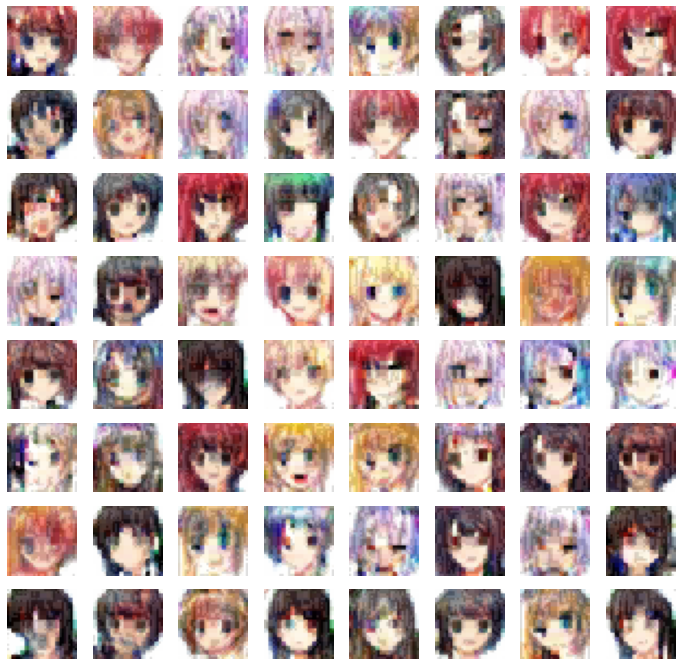

938/938 [==============================] - 420s 425ms/step - d_loss: -10.7108 - g_loss: 56.0540
Epoch 2/8
938/938 [==============================] - ETA: 0s - d_loss: -10.8280 - g_loss: 63.6922

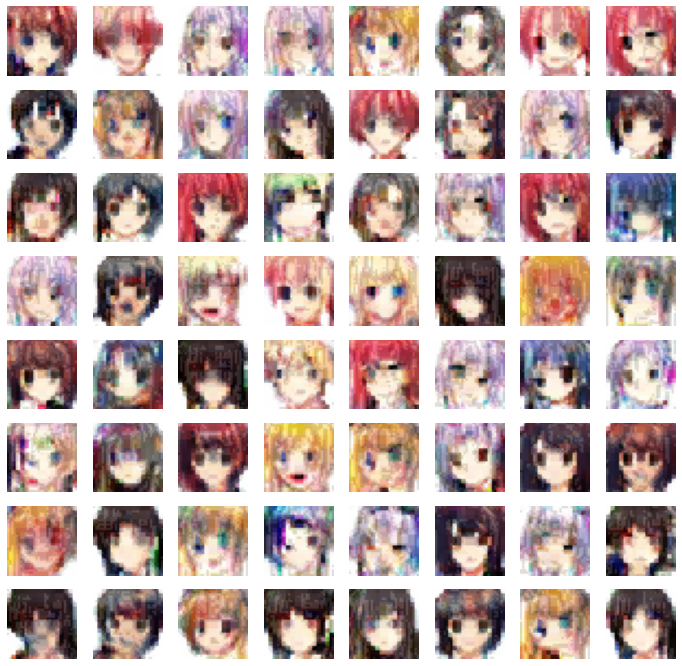

938/938 [==============================] - 401s 427ms/step - d_loss: -10.8250 - g_loss: 63.6256
Epoch 3/8
938/938 [==============================] - ETA: 0s - d_loss: -10.9519 - g_loss: 64.1717

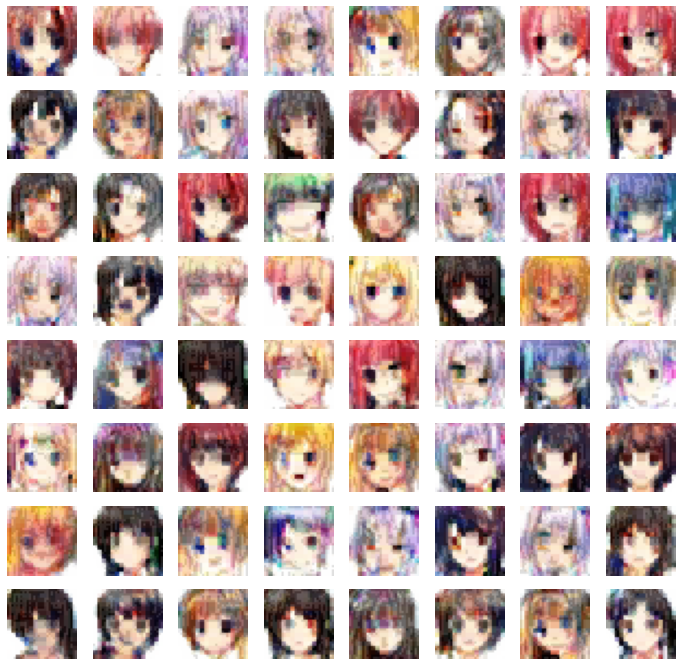

938/938 [==============================] - 402s 428ms/step - d_loss: -10.9498 - g_loss: 64.1820
Epoch 4/8
938/938 [==============================] - ETA: 0s - d_loss: -11.0327 - g_loss: 67.8713

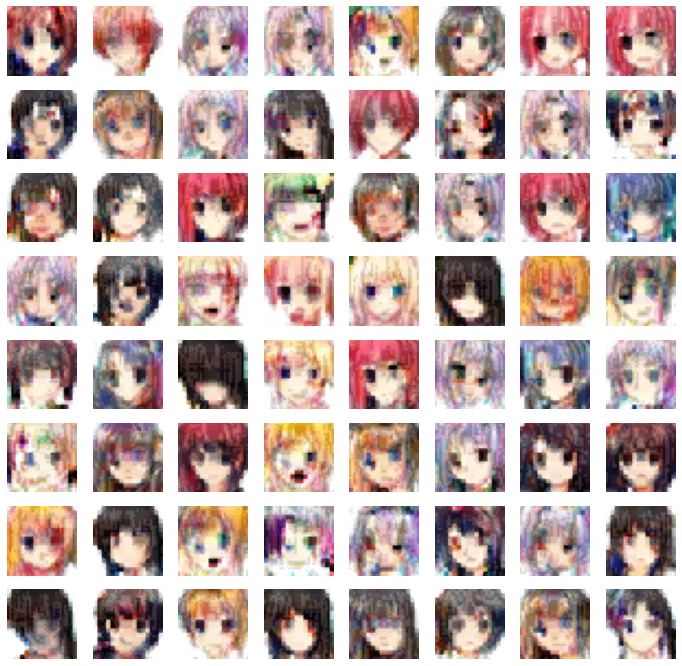

938/938 [==============================] - 401s 427ms/step - d_loss: -11.0308 - g_loss: 67.9216
Epoch 5/8
938/938 [==============================] - ETA: 0s - d_loss: -11.1291 - g_loss: 68.8224

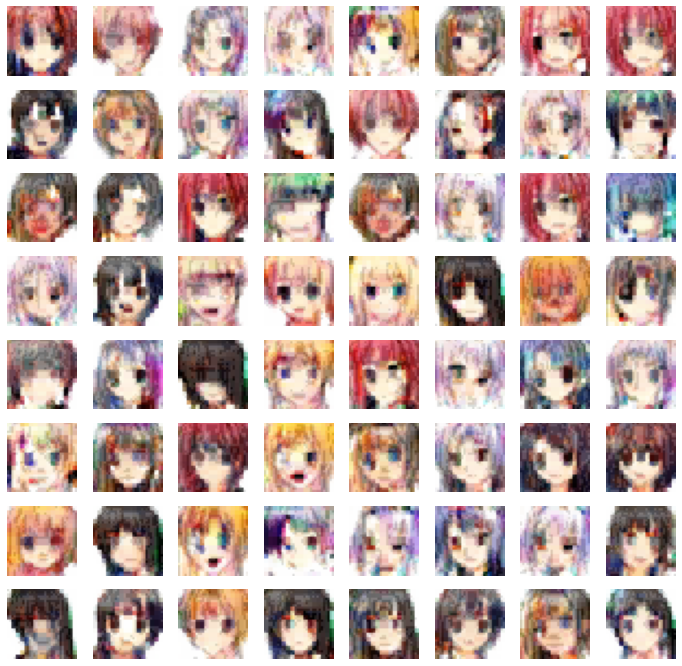

938/938 [==============================] - 400s 427ms/step - d_loss: -11.1259 - g_loss: 68.8087
Epoch 6/8
938/938 [==============================] - ETA: 0s - d_loss: -11.2278 - g_loss: 69.3052

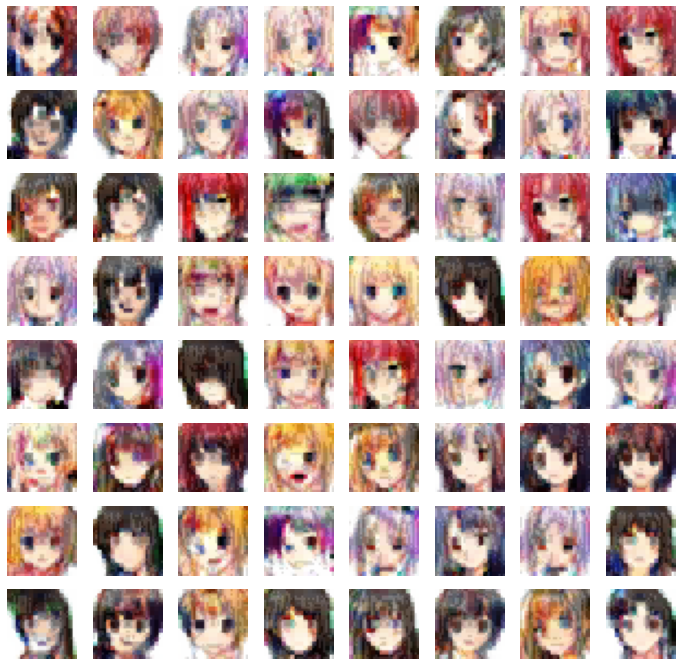

938/938 [==============================] - 399s 426ms/step - d_loss: -11.2264 - g_loss: 69.2822
Epoch 7/8
938/938 [==============================] - ETA: 0s - d_loss: -11.1804 - g_loss: 71.1360

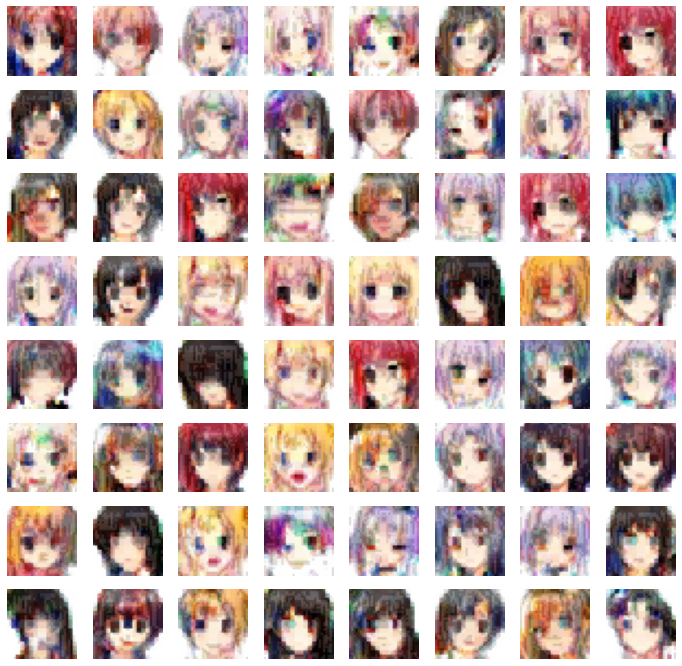

938/938 [==============================] - 401s 427ms/step - d_loss: -11.1771 - g_loss: 71.1676
Epoch 8/8
938/938 [==============================] - ETA: 0s - d_loss: -11.2796 - g_loss: 73.9627

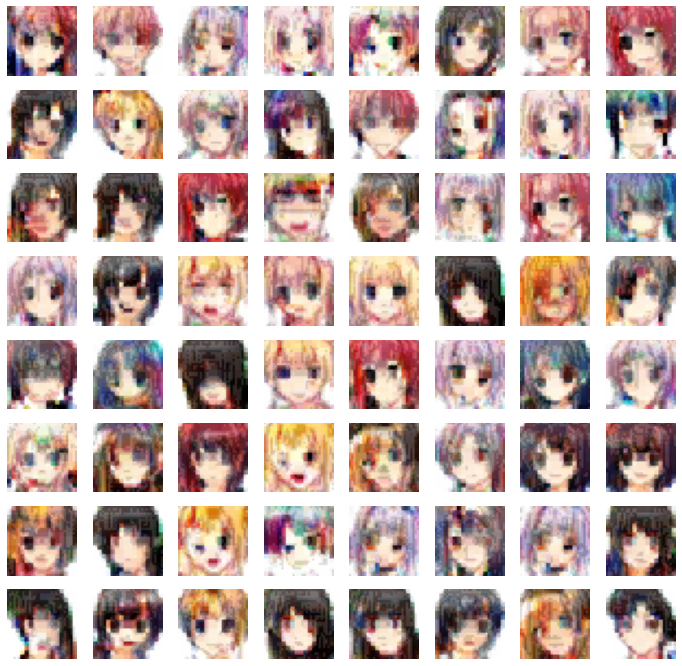

938/938 [==============================] - 400s 426ms/step - d_loss: -11.2774 - g_loss: 73.9457
Epoch 1/10
938/938 [==============================] - ETA: 0s - d_loss: 60.8121 - g_loss: 75.6383

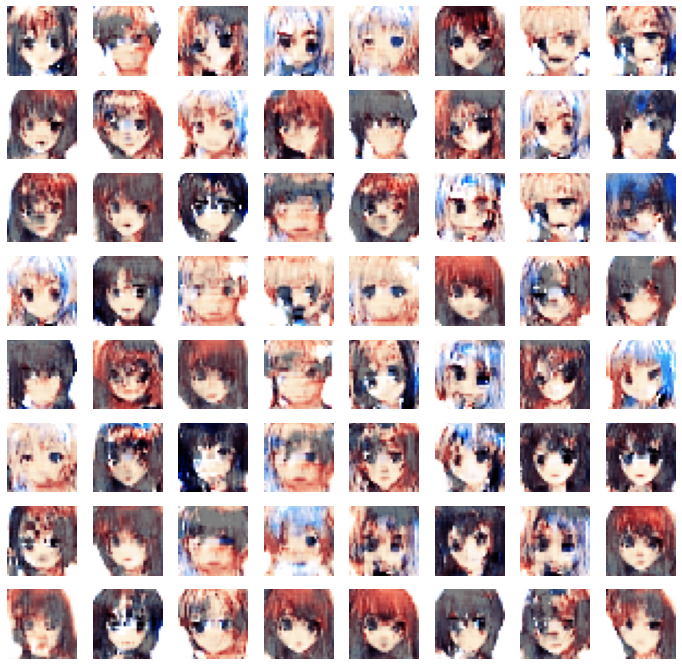

938/938 [==============================] - 363s 383ms/step - d_loss: 60.7447 - g_loss: 75.4142
Epoch 2/10
938/938 [==============================] - ETA: 0s - d_loss: 57.2974 - g_loss: 10.8108

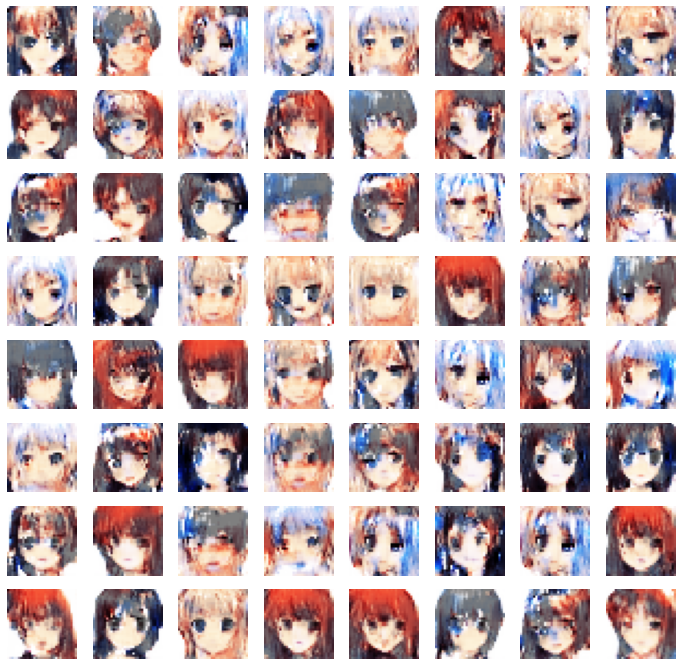

938/938 [==============================] - 360s 383ms/step - d_loss: 57.2414 - g_loss: 11.1742
Epoch 3/10
938/938 [==============================] - ETA: 0s - d_loss: 10.8302 - g_loss: 25.0832

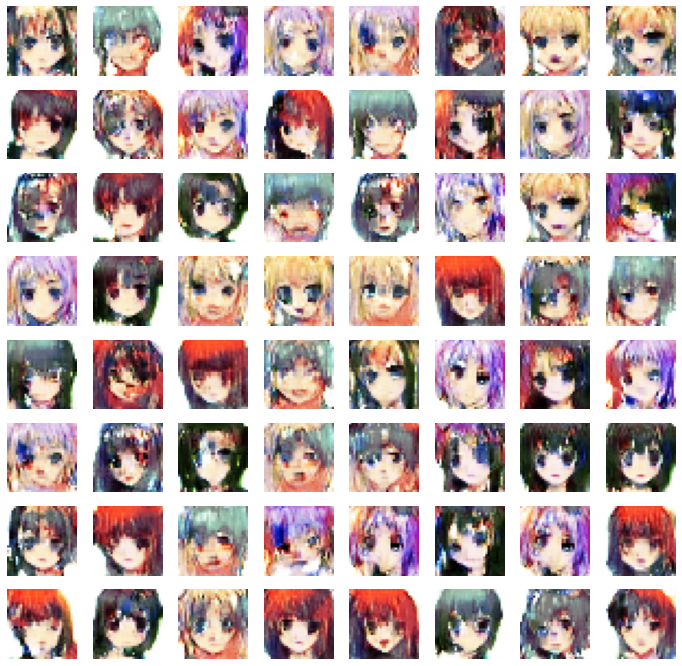

938/938 [==============================] - 359s 383ms/step - d_loss: 10.8151 - g_loss: 25.1901
Epoch 4/10
938/938 [==============================] - ETA: 0s - d_loss: 12.5522 - g_loss: 16.5505

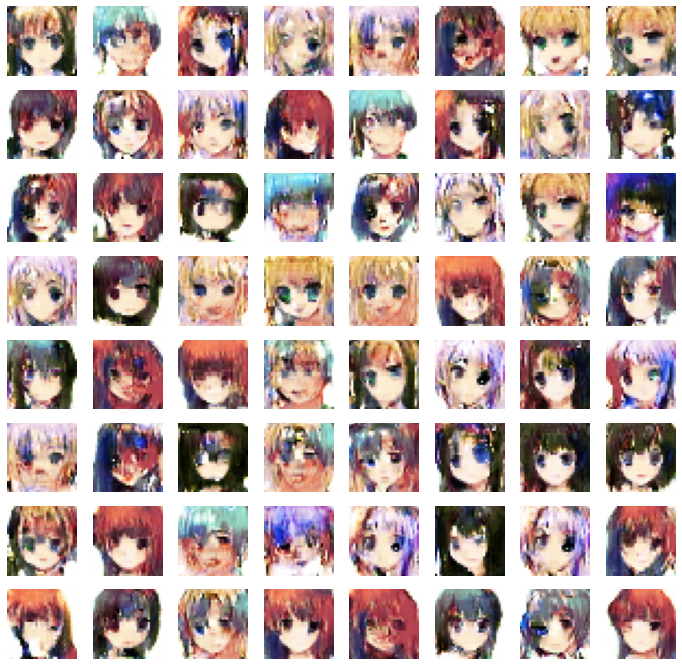

938/938 [==============================] - 360s 383ms/step - d_loss: 12.5361 - g_loss: 16.5363
Epoch 5/10
484/938 [==============>...............] - ETA: 2:52 - d_loss: -0.2726 - g_loss: 34.5302

In [ ]:
train(g_model,d_model,dataset,latent_dim,n_epoch_fade,n_epoch_normal,batch_size,fixed_seed,dataset_size)

In [ ]:
generator = g_models[2][0]
seed = tf.random.normal((8*8,latent_dim))
generated_images = generator.predict(seed)
fig = plt.figure(figsize=(10,10))
for i in range(generated_images.shape[0]): 
    plt.subplot(8,8,i+1)
    plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
    plt.axis("off")
plt.show()